In [1]:
!nvidia-smi

Sat Nov  9 12:49:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.183      Driver Version: 384.183      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000C93:00:00.0 Off |                    0 |
| N/A   46C    P0    72W / 149W |   2486MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00002BD8:00:00.0 Off |                    0 |
| N/A   61C    P0    61W / 149W |   2226MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

In [8]:
anomaly_digit = 0
batch_size = 256

In [9]:
not_ano_dataset = dset.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

condition = not_ano_dataset.targets != anomaly_digit
not_ano_dataset.data = not_ano_dataset.data[condition]
not_ano_dataset.targets = not_ano_dataset.targets[condition]

not_ano_loader = torch.utils.data.DataLoader(dataset=not_ano_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

In [5]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3, padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [48]:
import torch
from torchvision.utils import make_grid

def run_an_experiment(lr, n_epochs = 20, sample_interval = 100):
    experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN—MNIST', workspace='Sirius-yandex-2019')
    
    experiment.log_parameter('n_epochs', n_epochs)
    experiment.log_parameter('lr', lr)

    generator = Generator().to('cuda')
    discriminator = Discriminator().to('cuda')

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=10*lr)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

    Tensor = torch.cuda.FloatTensor

    adversarial_loss = torch.nn.BCELoss()

    batches_done = 0
    
    generator.train()
    discriminator.train()

    for epoch in range(n_epochs):

        for i, (imgs, _) in enumerate(not_ano_loader):
            
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to('cuda')
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to('cuda')


            real_imgs = Variable(imgs.type(Tensor).cuda())

            optimizer_G.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100)))).to('cuda')
            fake_imgs = generator(z)
            
            loss_G = adversarial_loss(discriminator(fake_imgs)[0], valid)
            loss_G.backward()
            optimizer_G.step()
            
            
            optimizer_D.zero_grad()
            
            err_r = adversarial_loss(discriminator(real_imgs)[0], valid)
            err_z = adversarial_loss(discriminator(fake_imgs.detach())[0], fake)
            loss_D = (err_r + err_z) / 2

            loss_D.backward()
            optimizer_D.step()

            experiment.log_metrics({'G': loss_G.item(), 'D': loss_D.item()}, epoch = epoch, step = batches_done)

            if batches_done % sample_interval == 0:
                plt.figure(figsize = (10,10))

                plt.title(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, n_epochs, batches_done % len(not_ano_loader), len(not_ano_loader), loss_D.item(), loss_G.item())
                )

                plt.imshow(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
                experiment.log_figure()
                plt.show()
            batches_done += 1

    experiment.end()
    return generator, discriminator

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist/37ab9338009448ae87fc8e5f954aea56
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [1646]                      : (0.060025617480278015, 1.367367148399353)
COMET INFO:     G [1646]                      : (0.48780518770217896, 3.370604991912842)
COMET INFO:     loss [329]                    : (0.06793555617332458, 2.566767930984497)
COMET INFO:     sys.gpu.0.free_memory [18]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [18]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [18]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [18]    : (7586840576.0, 7586840576.0)
COMET INFO:     sys.gpu.1.gpu_utilization [18]: (0.0, 94.0)
COMET INFO:     sys.gpu.1.total_memory        : (119

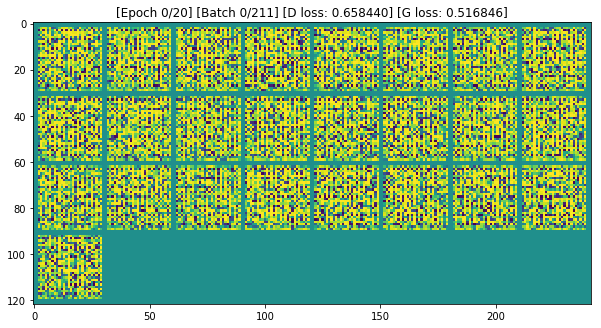

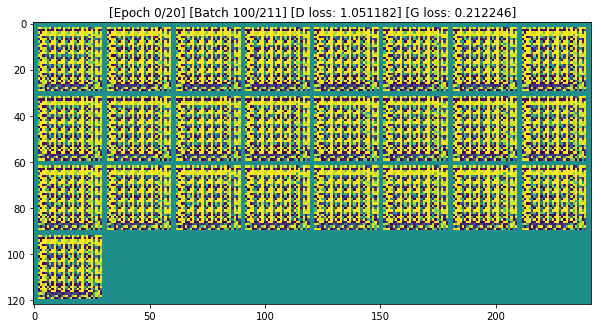

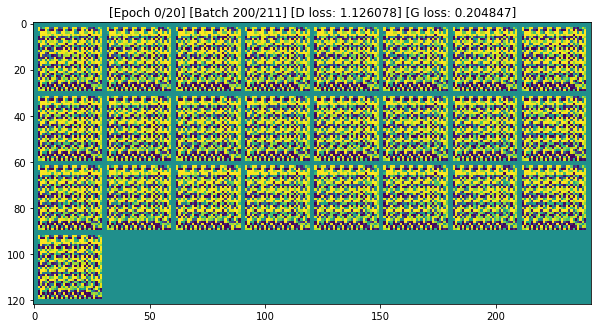

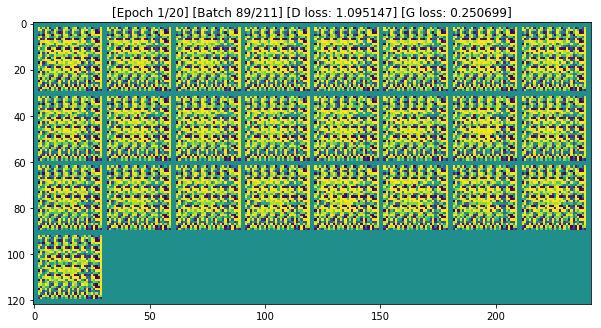

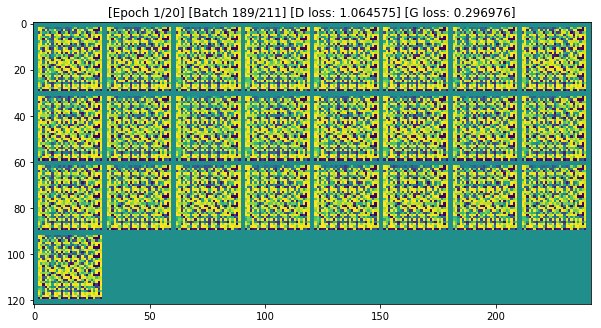

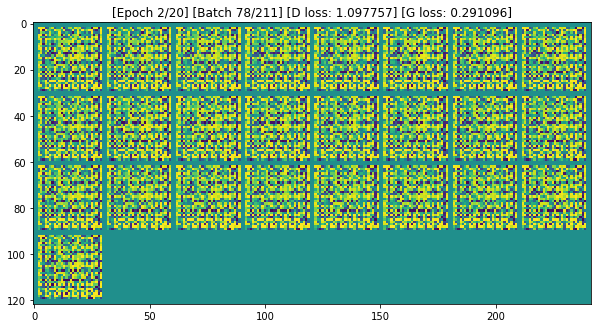

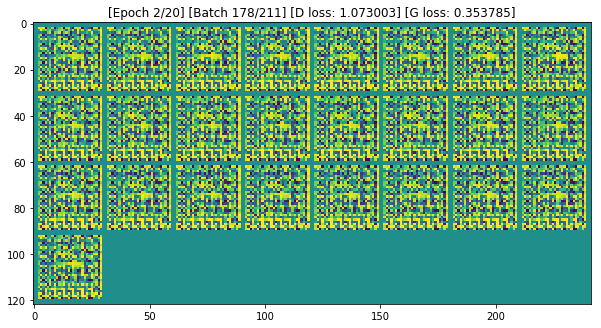

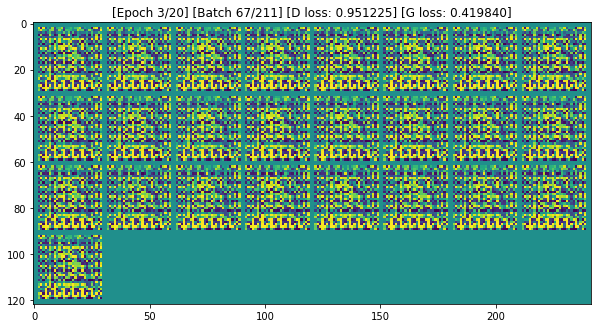

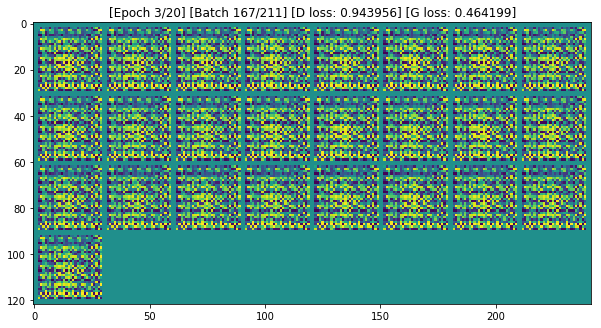

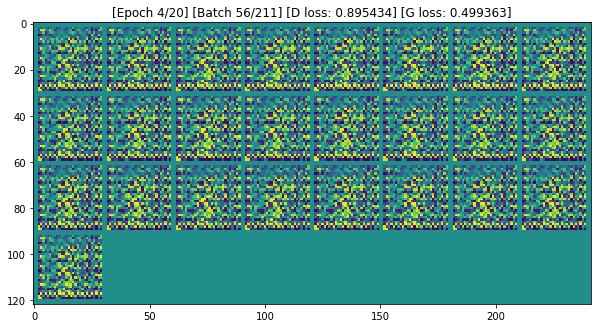

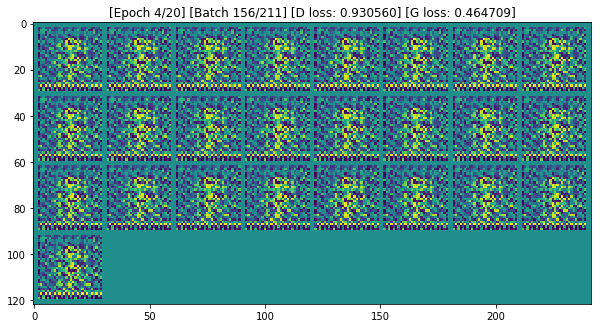

COMET ERROR: File could not be uploaded


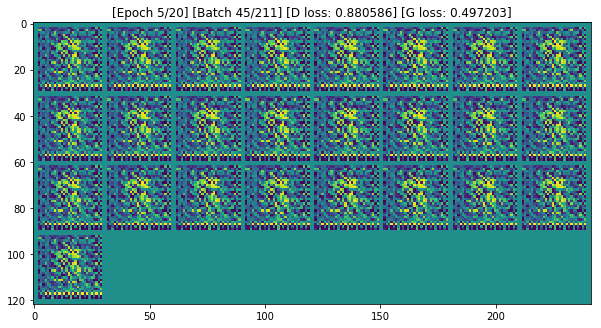

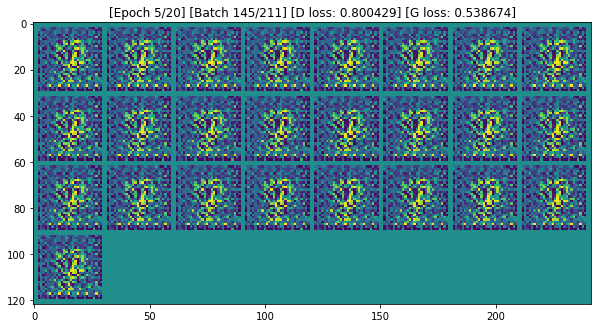

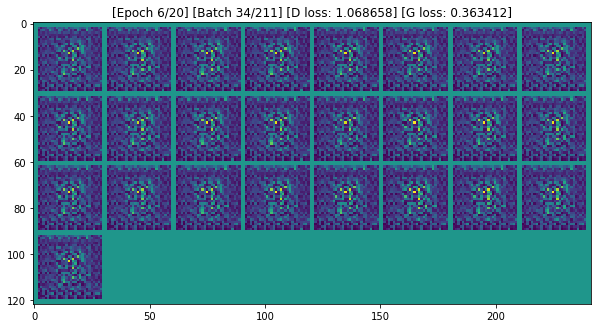

COMET ERROR: File could not be uploaded


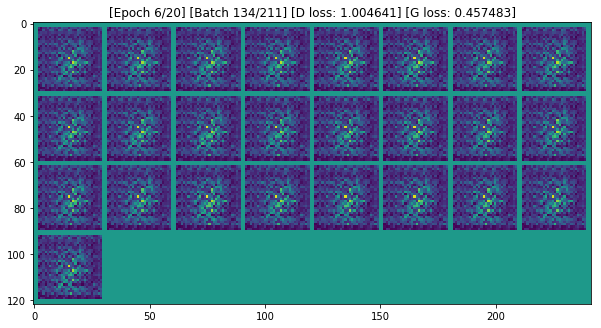

COMET ERROR: File could not be uploaded


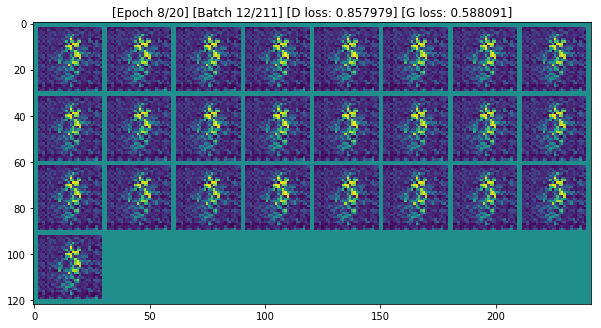

COMET ERROR: File could not be uploaded


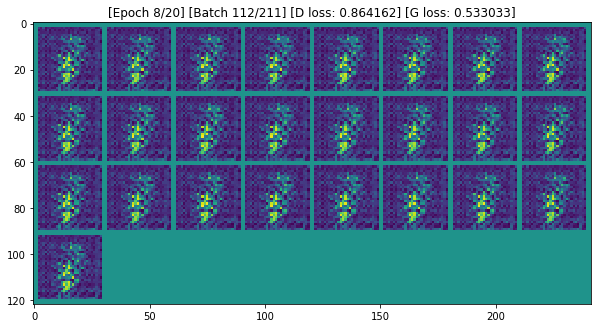

COMET ERROR: File could not be uploaded


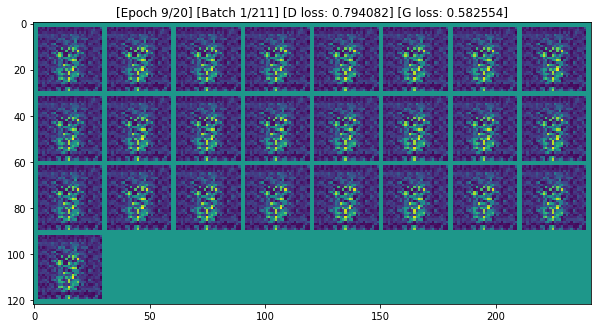

COMET ERROR: File could not be uploaded


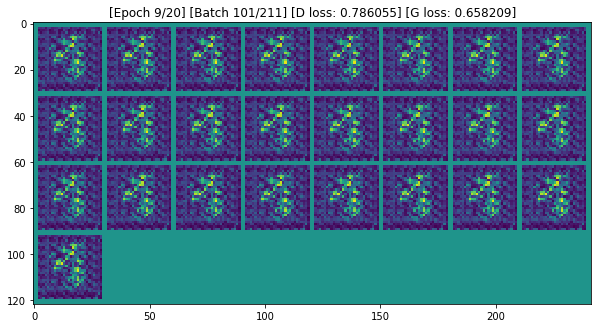

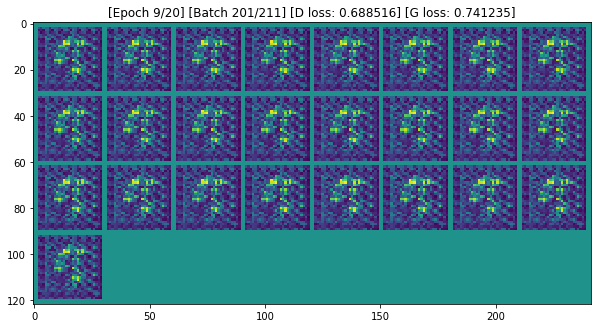

COMET ERROR: File could not be uploaded


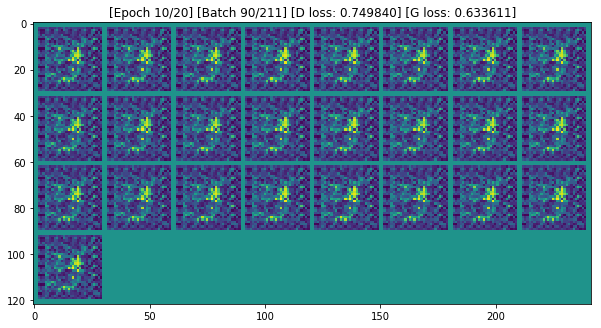

COMET ERROR: File could not be uploaded


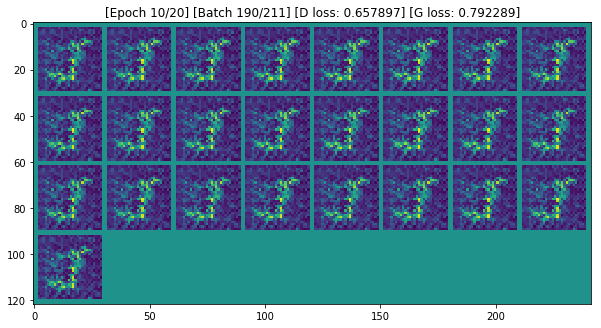

COMET ERROR: File could not be uploaded


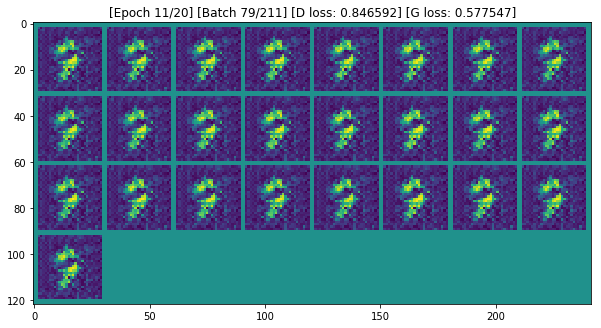

COMET ERROR: File could not be uploaded


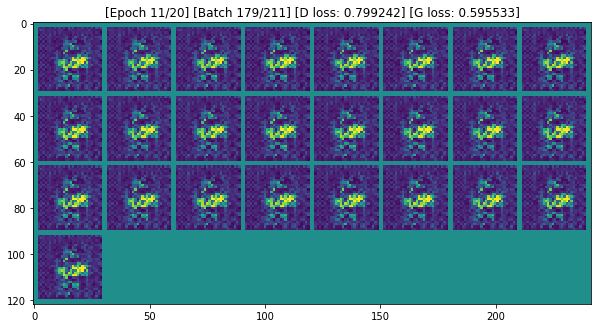

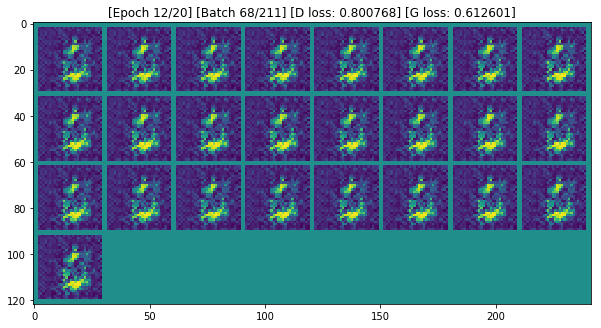

COMET ERROR: File could not be uploaded


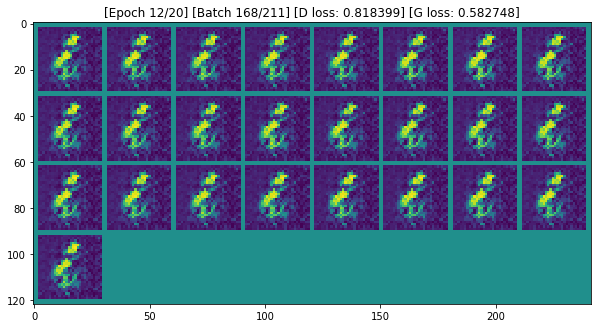

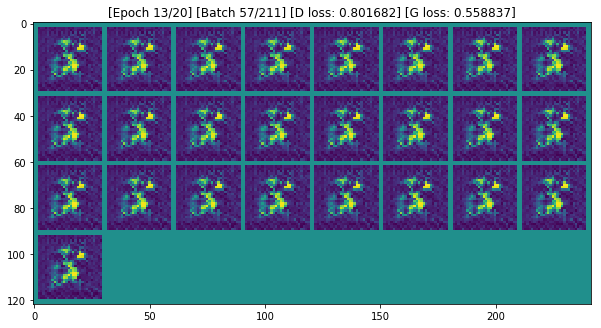

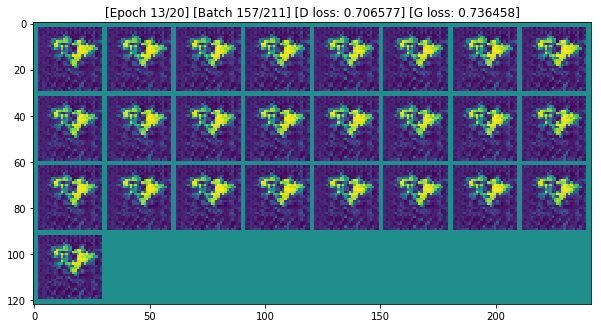

COMET ERROR: File could not be uploaded


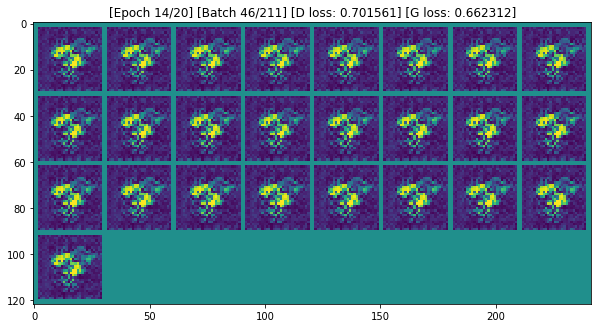

COMET ERROR: File could not be uploaded


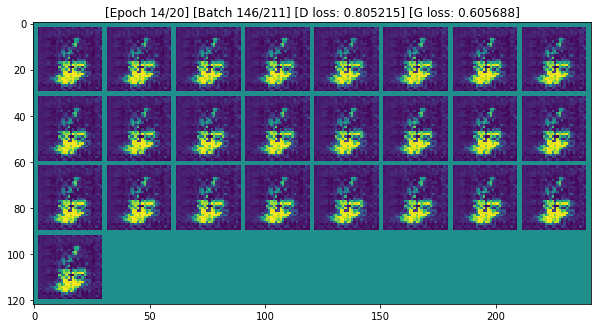

COMET ERROR: File could not be uploaded


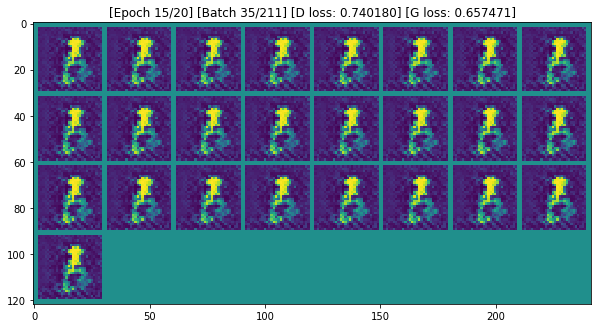

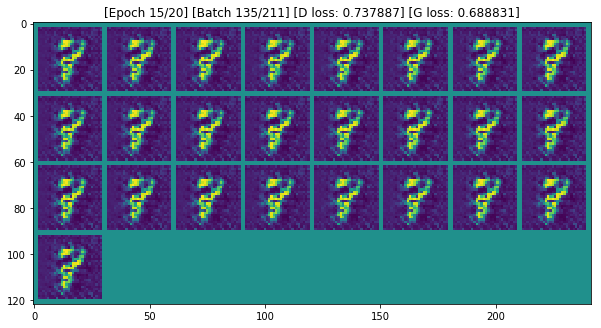

In [ ]:
generator, discriminator  = run_an_experiment(0.0002)

In [ ]:
import time;
ts = time.time()

for i, model in enumerate([generator, discriminator]):
    torch.save(model.state_dict(), "./models/"+str(ts)+"__"+str(i)+".pt")